In [1]:
#require "owl-top"
#require "owl-ode"
#require "juplot"

/Users/mseri/.opam/4.08.1+flambda/lib/ocaml/unix.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/ocaml/bigarray.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/bytes: added to search path
/Users/mseri/.opam/4.08.1+flambda/lib/integers: added to search path
/Users/mseri/.opam/4.08.1+flambda/lib/integers/integers.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/ctypes: added to search path
/Users/mseri/.opam/4.08.1+flambda/lib/ctypes/ctypes.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/ctypes/ctypes-top.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/ocaml/str.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/ctypes/cstubs.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/eigen/cpp: added to search path
/Users/mseri/.opam/4.08.1+flambda/lib/eigen/cpp/eigen_cpp.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/eigen: added to search path
/Users/mseri/.opam/4.08.1+flambda/lib/eigen/eigen.cma: loaded
/Users/mseri/.opam/4.08.1+flambda/lib/owl-base: added to search path
/Users/mser

# N-Body system

We generate 1000 normally distributed bodies around 0 and of equal mass, and define the energy and the potential of the system.

In [2]:
open Owl

let n_planets = 1000

(* Each row in this matrix represents the position of a celestial body *)
let planets = Mat.gaussian n_planets 3

(* Each row in this matrix represents the velocity of a celestial body, *)
(* we start with stationary bodies. *)
let planetvs = Mat.zeros n_planets 3

(* This is only needed to avoid a division by 0*)
let shift = Mat.of_array [|1E-12|] 1 1

(* Compute the matrix of forces acting on each celestial body *)
let nbody_owl planets =
  let force = Mat.zeros n_planets 3 in
  for i = 0 to n_planets - 1 do
    let open Mat in
    let dp = planets - planets.${[ [ i ]; [] ]} in
    let dr_sqr = l2norm_sqr ~axis:1 dp in
    let dr_pow_n32 = 1. $/ max2 (dr_sqr + sqrt dr_sqr) shift in
    force.${[ []; [] ]} <- (force.${[ []; [] ]} - (dp * dr_pow_n32))
  done;
  force

(* The evolution function used by our symplectic integrators takes a tuple *)
(* of (position,velocity) and the time t. *)
let f (planets, _) _ = nbody_owl planets

(* Energy of the system *)
let energy planets planetvs =
  let open Mat in
  let e = ref @@ sum' (l2norm_sqr ~axis:1 planetvs *$ 0.5) in
  for i = 0 to pred n_planets do
    let dp = planets - planets.${[ [ i ]; [] ]} in
    let dr_sqr = l2norm_sqr ~axis:1 dp in
    let dr_pow_n32 = 1. $/ max2 (dr_sqr + sqrt dr_sqr) shift in
    e := !e -. sum' dr_pow_n32
  done;
  !e

val n_planets : int = 1000


val planets : Owl.Mat.mat =
  
            C0         C1         C2 
  R0 -0.986866   0.152131   0.156151 
  R1  -1.38803   0.339936   0.889166 
  R2  -1.47812   0.644961   -2.35465 
  R3   1.39714  -0.273945    1.52143 
  R4  0.423081  -0.983885   0.249035 
           ...        ...        ... 
R995  0.199649   -2.32786    2.33969 
R996 -0.451986 -0.0264981 -0.0399787 
R997 -0.445599    1.11314   0.524585 
R998  0.719888     1.3135    1.28845 
R999  0.972231    0.18114  0.0459814 



val planetvs : Owl.Mat.mat =
  
      C0  C1  C2 
  R0   0   0   0 
  R1   0   0   0 
  R2   0   0   0 
  R3   0   0   0 
  R4   0   0   0 
     ... ... ... 
R995   0   0   0 
R996   0   0   0 
R997   0   0   0 
R998   0   0   0 
R999   0   0   0 



val shift : Owl.Mat.mat = 
      C0 
R0 1E-12 



val nbody_owl :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t -> Owl.Mat.mat =
  <fun>


val f :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t * 'a ->
  'b -> Owl.Mat.mat = <fun>


val energy :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t ->
  Owl.Mat.mat -> Owl.Mat.elt = <fun>


# Integration of the system

In [3]:
(* How many steps we will integrate *)
let n = 80

(* Initial conditions *)
let y0 = planets, planetvs

(* We perform n integration steps with a fixed stepsize dt and t0=0 *)
let tspec = 
    let dt = 0.5 in
    Owl_ode.Types.T1 { t0 = 0.0; dt; duration = float_of_int n *. dt}

val n : int = 80


val y0 : Owl.Mat.mat * Owl.Mat.mat =
  (
            C0         C1         C2 
  R0 -0.986866   0.152131   0.156151 
  R1  -1.38803   0.339936   0.889166 
  R2  -1.47812   0.644961   -2.35465 
  R3   1.39714  -0.273945    1.52143 
  R4  0.423081  -0.983885   0.249035 
           ...        ...        ... 
R995  0.199649   -2.32786    2.33969 
R996 -0.451986 -0.0264981 -0.0399787 
R997 -0.445599    1.11314   0.524585 
R998  0.719888     1.3135    1.28845 
R999  0.972231    0.18114  0.0459814 
,
   
      C0  C1  C2 
  R0   0   0   0 
  R1   0   0   0 
  R2   0   0   0 
  R3   0   0   0 
  R4   0   0   0 
     ... ... ... 
R995   0   0   0 
R996   0   0   0 
R997   0   0   0 
R998   0   0   0 
R999   0   0   0 
)


val tspec : Owl_ode.Types.tspec =
  Owl_ode.Types.T1 {Owl_ode.Types.t0 = 0.; duration = 40.; dt = 0.5}


In [4]:
(* Symmplectic integrators return the time span, *)
(* an ndarray of positions at each time and *)
(* an ndarray of velocities at each time. *)

let tspan, sol_planets, sol_planetevs = Owl_ode.(
    Ode.odeint Symplectic.D.leapfrog f y0 tspec ()
)

val tspan : Owl_ode.Symplectic.D.mat =
  
      C0 
 R0    0 
 R1  0.5 
 R2    1 
 R3  1.5 
 R4    2 
     ... 
R76   38 
R77 38.5 
R78   39 
R79 39.5 
R80   40 

val sol_planets : Owl_ode.Symplectic.D.mat =
  
           C0       C1        C2       C3       C4        C2995    C2996    C2997    C2998     C2999 
 R0 -0.986866 0.152131  0.156151 -1.38803 0.339936 ...   1.3135  1.28845 0.972231  0.18114 0.0459814 
 R1   19.3207 -3.86188  -3.74762  20.7607 -5.12447 ...  -17.463 -17.9208 -18.5607 -3.99068  -1.52382 
 R2   35.4167 -6.96287   -6.7676  38.3449 -9.46051 ... -32.3824 -32.9206 -34.0567  -7.2225  -2.69334 
 R3   49.2181 -9.56692  -9.30224  53.4397 -13.1793 ... -45.1672 -45.5886 -47.3564 -9.94277  -3.64353 
 R4   61.3676 -11.8133  -11.4869  66.7435 -16.4528 ... -56.4057 -56.5681 -59.0761 -12.2957  -4.43611 
          ...      ...       ...      ...      ... ...      ...      ...      ...      ...       ... 
R76   57.4936  86.9903  -6.51997 -178.855 -6.75174 ... -23.1368  -57.476 -7

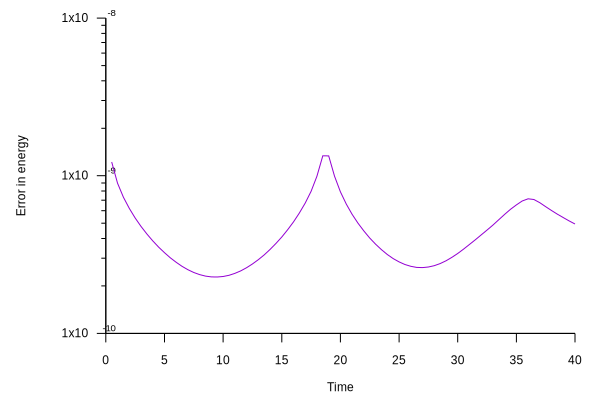

In [5]:
let () =
    let energies = Mat.zeros (n+1) 2 in
    let e0 = energy planets planetvs in
    for i=0 to n do
        Mat.set energies i 0 (Mat.get tspan i 0);
        Mat.set energies i 1 Mat.(
        energy  (reshape (row sol_planets i)  [|1000; 3|])
                (reshape (row sol_planetevs i)  [|1000; 3|])
            /. e0
            -. 1.0
        |> abs_float
        );
    done;
    let figure (module F: Gp.Plot) =
        let props = Gp.[ylabel "Error in energy"; xlabel "Time"; set "logscale y"] in
        F.plot (A energies) ~using:"1:2" ~style:"l" props
    in
    Juplot.draw figure

# Can we animate the bodies?

In [6]:
(* This function produces a 3d scatter plot specification for a given matrix of planets *)
let plot i planets = fun (module F: Gp.Plot) ->
    let props = Gp.[
        unset "xtics"
      ; unset "ytics"
      ; unset "ztics"
      ; title @@ string_of_int i
    ] in
    F.splot (A planets) ~using:"1:2:3" ~style:"p pt 7 ps 0.5" props

val plot : int -> Owl.Mat.mat -> (module Gp.Plot) -> unit = <fun>


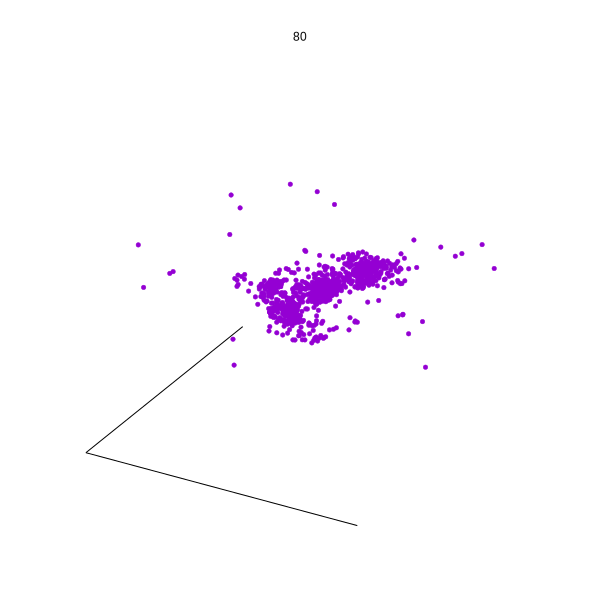

val display_id : Jupyter_notebook.display_id = <abstr>


In [7]:
(* We fix a notebook box (display_id) and iterate over all planet *)
(* configurations, plotting the configuration on the box and *)
(* wating 0.05 seconds before continuing again. *)

let display_id = Jupyter_notebook.display "text/html" ""
let () =
    Mat.iteri_rows (fun i planets ->
        let planets = Mat.(reshape planets [|1000; 3|]) in
        Juplot.draw ~fmt:`svg ~size:(600,600) ~display_id (plot i planets);
        Unix.sleepf 0.05
    ) sol_planets

### Can we do it on the fly?

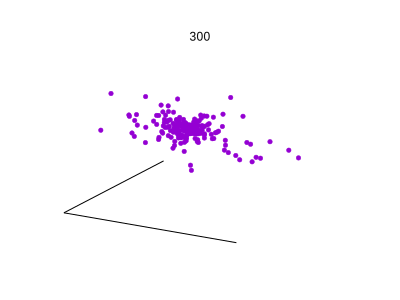

val did : Jupyter_notebook.display_id = <abstr>


In [8]:
let did = Jupyter_notebook.display "text/html" ""

In [9]:
let () =
    let frames = 300 in
    let np = 200 in
    let dt = 0.5 in
    
    let y0 = ref (
        planets.Mat.${[[0;np-1];[]]},
        planetvs.Mat.${[[0;np-1];[]]}) 
    in
    
    let nbody_owl (planets, _) _ =
      let force = Mat.zeros np 3 in
      for i = 0 to np - 1 do
        let open Mat in
        let dp = planets - planets.${[ [ i ]; [] ]} in
        let dr_sqr = l2norm_sqr ~axis:1 dp in
        let dr_pow_n32 = 1. $/ max2 (dr_sqr + sqrt dr_sqr) shift in
        set dr_pow_n32 i 0 0.0;
        force.${[ []; [] ]} <- (force.${[ []; [] ]} - (dp * dr_pow_n32))
      done;
      force
    
    in
    for i=0 to frames do
        let planets = Mat.(reshape (fst !y0) [|np; 3|]) in
        Juplot.draw
            ~fmt:`svg ~size:(400,300) ~display_id:did (plot i planets);
        y0 := fst @@ Owl_ode.Symplectic.D.Leapfrog.step nbody_owl ~dt !y0 0.0
    done